In [2]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import healpy as hp
import schnell as snl
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib import rc
import itertools as it
rc('font', **{'family': 'sans-serif',
              'sans-serif': ['Helvetica']})
rc('text', usetex=False)

rc('font', size=14)
rc('legend', fontsize=13)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('axes', labelsize=16)

default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'k']) +
                  cycler(linestyle=['-', '--', ':', '-.', (0, (3, 1, 1, 1, 1, 1))]))
rc('axes', prop_cycle=default_cycler)

lisa_old = [snl.LISADetector(i, is_L5Gm=True) for i in range(3)]
lisa = [snl.LISADetector(i, is_L5Gm=False) for i in range(3)]
alia = [snl.ALIADetector(i) for i in range(3)]
lisalia = [snl.LISAandALIADetector(i) for i in range(6)]
twolisas = [snl.TwoLISADetector(i) for i in range(6)]
#star = [snl.BBOStarDetector(i) for i in range(6)]
#mlisa_2 = [snl.MultipleLISADetector(i, 2) for i in range(6)]
#mlisa_5 = [snl.MultipleLISADetector(i, 5) for i in range(15)]

range_mlisas = [4]
mlisas = [[snl.MultipleLISADetector(i, n) for i in range(3*n)] for n in range_mlisas]

#malia2 = [snl.MultipleALIADetector(i, 2) for i in range(6)]
#malia3 = [snl.MultipleALIADetector(i, 3) for i in range(9)]
#lisalia_opp = [snl.LISAandALIADetector(i, separation=2) for i in range(6)]
range_malias = [2,3,4,5,6]
malias = [[snl.MultipleALIADetector(i, n) for i in range(3*n)] for n in range_malias]



from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Run of {}".format(current_time))

Run of 16:59:56


In [5]:
t_obs = 4 # years
obs_time = t_obs * 365 * 24 * 3600
freqs = np.geomspace(1E-4, 0.2, 1001)
f_ref = 1E-2
nside = 64

freqs_lr = np.geomspace(1E-4, 0.2, 101)
nside_lr = 32

npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
f_obs = 1e-2

rhoLO = snl.NoiseCorrelationLISA(lisa_old[0])
rhoL = snl.NoiseCorrelationLISA(lisa[0])
rhoA = snl.NoiseCorrelationLISAlike(alia[0])
rhoLA = snl.NoiseCorrelationLISALIA(lisalia[0])
rhoTL = snl.NoiseCorrelationTwoLISA(twolisas[0])
#rhoML_2 = snl.NoiseCorrelationMultipleSpaceDetectors(mlisa_2[0])
#rhoML_5 = snl.NoiseCorrelationMultipleSpaceDetectors(mlisa_5[0])

rho_mlisas = [snl.NoiseCorrelationMultipleSpaceDetectors(mlisas[n][0]) for n in range(len(mlisas))]
rho_malias = [snl.NoiseCorrelationMultipleSpaceDetectors(malias[n][0]) for n in range(len(malias))]

#rhoMA_2 = snl.NoiseCorrelationMultipleSpaceDetectors(malia2[0])
#rhoMA_3 = snl.NoiseCorrelationMultipleSpaceDetectors(malia3[0])


mcLO = snl.MapCalculator(lisa_old, f_pivot=f_ref,
                       corr_matrix=rhoLO)
mcL = snl.MapCalculator(lisa, f_pivot=f_ref,
                       corr_matrix=rhoL)
mcA = snl.MapCalculator(alia, f_pivot=f_ref,
                       corr_matrix=rhoA)
mcLA = snl.MapCalculator(lisalia, f_pivot=f_ref,
                       corr_matrix=rhoLA)
mcTL = snl.MapCalculator(twolisas, f_pivot=f_ref,
                       corr_matrix=rhoTL)
#mcML_2 = snl.MapCalculator(mlisa_2, f_pivot=f_ref,
#                       corr_matrix=rhoML_2)
#mcML_5 = snl.MapCalculator(mlisa_5, f_pivot=f_ref,
#                       corr_matrix=rhoML_5)

mc_mlisas = [snl.MapCalculator(mlisas[n], f_pivot=f_ref,
                       corr_matrix=rho_mlisas[n]) for n in range(len(mlisas))]
mc_malias = [snl.MapCalculator(malias[n], f_pivot=f_ref,
                       corr_matrix=rho_malias[n]) for n in range(len(malias))]


#mcMA_2 = snl.MapCalculator(malia2, f_pivot=f_ref,
#                       corr_matrix=rhoMA_2)
#mcMA_3 = snl.MapCalculator(malia3, f_pivot=f_ref,
#                       corr_matrix=rhoMA_3)
#mcLAopp = snl.MapCalculator(lisalia_opp, f_pivot=f_ref,
#                       corr_matrix=rhoLA)

start_color = np.array((0, 0, 0, 1))
end_color = np.array((0, 1, 1, 1))
def choose_color(i, n, st_c=start_color, en_c=end_color):
    return st_c + (en_c-st_c) * i / n

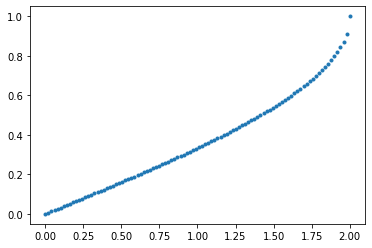

In [20]:
baselines = np.linspace(0, 2, 100)
ang_seps = 2 * np.arcsin(baselines / 2)
plt.plot(baselines, ang_seps / np.pi, '.')

## Comparing with David's code

In [6]:
from scipy.linalg import block_diag

def get_NALIA_mapper(n, lam=0):
    dets = []
    for i in range(n):
        #dets_this = [snl.LISADetector(j, kappa=2*np.pi*i/n) for j in range(3)]
        dets_this = [snl.ALIADetector(j) for j in range(3)]
        for j in range(3):
            dets_this[j].kap = 2*np.pi*i/n
            dets_this[j].lam = lam
        dets += dets_this
    r_ALIA = snl.NoiseCorrelationLISAlike(dets[0])
    if n == 1:
        rho = r_ALIA
    else:
        #rho = snl.NoiseCorrelationBoxDiagonal([r_LISA]*n)
        rho = NoiseCorrelationBoxDiagonal([r_ALIA]*n)
    f_ref = 1E-2
    mc = snl.MapCalculator(dets, f_pivot=f_ref, corr_matrix=rho)
    return mc

class NoiseCorrelationBoxDiagonal(snl.NoiseCorrelationBase):
    """ This implements a correlation matrix from a set of
    noise correlation objects. The resulting matrix will be
    the combination of all correlation matrices in a
    block-diagonal way.
    Args:
        corrs: list of `NoiseCorrelationBase` objects.
    """
    def __init__(self, corrs):
        if not isinstance(corrs, list):
            raise TypeError("`corr` must be a list of "
                            "`NoiseCorrelation` objects.")
        self.ncorrs = len(corrs)
        for c in corrs:
            if not isinstance(c, snl.NoiseCorrelationBase):
                raise TypeError("`corr` must be a list of "
                                "`NoiseCorrelation` objects.")
        self.corrs = corrs
        self.ndet = np.sum([c.ndet for c in self.corrs])

    def _get_corrmat(self, f):
        f_use = np.atleast_1d(f)
        mats = np.array([c.get_corrmat(f_use)
                         for c in self.corrs])
        mat = np.zeros([len(f_use), self.ndet, self.ndet])
        for i, freq in enumerate(f_use):
            ms = mats[:, i, :, :]
            mat[i, :, :] = block_diag(*ms)
        return mat

def get_Nl_multiALIA(n):
    t_obs = 4
    nside = 32
    m = get_NALIA_mapper(n)
    freqs = np.geomspace(1E-4, 1, 201)
    obs_time = t_obs * 365 * 24 * 3600
    nl = m.get_N_ell(obs_time, freqs, nside,
                     is_fspacing_log=True)
    ls = np.arange(3*nside)
    return ls, nl


In [14]:
ls, nltest_MA3 = get_Nl_multiALIA(3)

In [5]:
with open('npy_saves/nlA.npy', 'rb') as file:
    nlA = np.load(file)

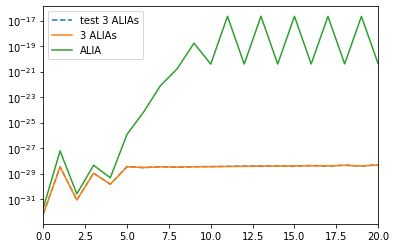

In [16]:
ls = np.arange(len(nlA))
plt.plot(ls, nltest_MA3, '--', label='test 3 ALIAs')
plt.plot(ls, nlMAs[0], label='3 ALIAs')
plt.plot(ls, nlA, label='ALIA')
#plt.plot(ls, nlMA6, label='6 ALIAs')

plt.xlim(0, 20)
plt.legend()
plt.yscale('log');

## Checking Multiple ALIAs

In [7]:
#nlMA3 = mcMA_3.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)
#nlMA2 = mcMA_2.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)
#nlLAopp = mcLAopp.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)
nlMAs = []
for n in range(len(malias)):
    nlMAs.append(mc_malias[n].get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True))
    np.save(f'npy_saves/nlMA_{range_malias[n]}.npy', nlMAs[-1])
    print(f'MA{range_malias[n]} done')

MA2 done
MA3 done
MA4 done
MA5 done


In [ ]:

ls = np.arange(len(nl_MAs[0]))

for i in range(len(nl_MAs)):
    plt.plot(ls[::2], ((ls+.5)*nl_MAs[i])[::2], color=choose_color(i, len(nl_MAs)), label=f'{i+1} ALIA')
    plt.plot(ls[1::2], ((ls+.5)*nl_MAs[i])[1::2], '--', color=choose_color(i, len(nl_MAs)))

plt.yscale('log')
plt.legend()
plt.xlim(0, 50)
plt.xlabel('$\ell$')
plt.ylabel('$(\ell + 0.5) * N_\ell$')
plt.title('Evolution of $N_\ell$ curve with number of ALIA')
plt.title('$N_\ell$ curves for different ALIA numbers in the constellation')
plt.savefig('nell_mls')
plt.show();

In [6]:
with open('npy_saves/nlA.npy', 'rb') as file:
    nl_MAs = [np.load(file)]
for n in range(2, 6):
    with open(f'npy_saves/nlMA_{n}.npy', 'rb') as file:
        nl_MAs.append(np.load(file))

In [12]:
np.savetxt('nell_MA.dat', np.array(nl_MAs))

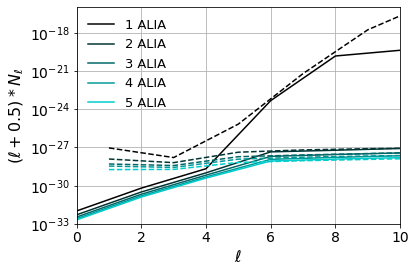

In [12]:
ls = np.arange(len(nl_MAs[0]))

for i in range(len(nl_MAs)):
    plt.plot(ls[::2], ((ls+.5)*nl_MAs[i])[::2], '-', color=choose_color(i, len(nl_MAs)), label=f'{i+1} ALIA')
    plt.plot(ls[1::2], ((ls+.5)*nl_MAs[i])[1::2], '--', color=choose_color(i, len(nl_MAs)))

plt.yscale('log')
plt.legend(frameon=False)
plt.ylim(1e-33, 1e-16)
plt.xlim(0, 10)
plt.xlabel('$\ell$', fontsize=16)
plt.ylabel('$(\ell + 0.5) * N_\ell$', fontsize=16)
#plt.title('Evolution of $N_\ell$ curve with number of ALIA')
#plt.title('$N_\ell$ curves for different ALIA numbers in the constellation')
plt.grid()
plt.tight_layout()
plt.savefig('figs_v2/nell_ma.pdf')
plt.show();

In [18]:
with open('npy_saves/nl_ML3.npy', 'rb') as file:
    nl_ML3 = np.load(file)
with open('npy_saves/nlL.npy', 'rb') as file:
    nlL = np.load(file)
with open('npy_saves/nl_ML2.npy', 'rb') as file:
    nl_ML2= np.load(file)

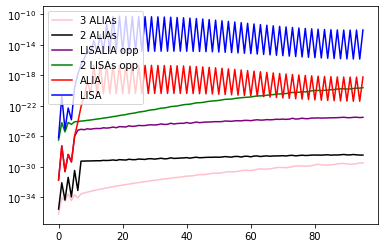

In [41]:
ls = np.arange(len(nlMA3))
plt.plot(ls, nlMA3, color='pink', label='3 ALIAs')
plt.plot(ls, nlLA_check, 'k', label='2 ALIAs')
plt.plot(ls, nlLAopp, color='purple', label='LISALIA opp')
plt.plot(ls, nl_ML2, 'g', label='2 LISAs opp')
plt.plot(ls, nlA, 'r', label='ALIA')
plt.plot(ls, nlL, 'b', label='LISA')
plt.yscale('log')
plt.legend(); 

## Computing MLs

In [48]:
nl_mlisas = []
for n in range(len(mlisas)):
    nl_mlisas.append(mc_mlisas[n].get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True))
    np.save(f'npy_saves/nl_ML{range_mlisas[n]}', nl_mlisas[-1])
    curr_time = datetime.now().strftime("%H:%M:%S")
    print(f'ML{range_mlisas[n]} done at {curr_time}')

ML2 done at 12:09:35


In [13]:
with open('npy_saves/nlL.npy', 'rb') as file:
    nlL = np.load(file)
with open('npy_saves/nl_ML2.npy', 'rb') as file:
    nl_ML2 = np.load(file)
with open('npy_saves/nl_ML3.npy', 'rb') as file:
    nl_ML3 = np.load(file)
with open('npy_saves/nl_ML4.npy', 'rb') as file:
    nl_ML4 = np.load(file)
with open('npy_saves/nl_ML5.npy', 'rb') as file:
    nl_ML5 = np.load(file)
with open('npy_saves/nl_ML6.npy', 'rb') as file:
    nl_ML6 = np.load(file)
with open('npy_saves/nl_ML7.npy', 'rb') as file:
    nl_ML7 = np.load(file)
with open('npy_saves/nl_ML8.npy', 'rb') as file:
    nl_ML8 = np.load(file)
with open('npy_saves/nl_ML9.npy', 'rb') as file:
    nl_ML9 = np.load(file)

nb_lisas = np.arange(1, 10)
nl_MLs = np.array([nlL, nl_ML2, nl_ML3, nl_ML4, nl_ML5, nl_ML6, nl_ML7, nl_ML8, nl_ML9])

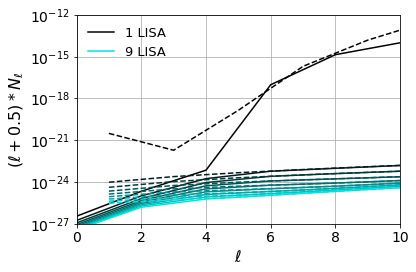

In [21]:
ls = np.arange(len(nlL))

for i in range(len(nl_MLs)):
    if i==0 or i==len(nl_MLs) -1:
        plt.plot(ls[::2], ((ls+.5)*nl_MLs[i])[::2], '-', color=choose_color(i, len(nl_MLs)), label=f'{nb_lisas[i]} LISA')
    else:
        plt.plot(ls[::2], ((ls+.5)*nl_MLs[i])[::2], '-', color=choose_color(i, len(nl_MLs)))
    plt.plot(ls[1::2], ((ls+.5)*nl_MLs[i])[1::2], '--', color=choose_color(i, len(nl_MLs)))
"""
plt.plot(ls[1::2], ((ls+.5)*nlL)[1::2], '--', label='1 LISA')
plt.plot(ls[1::2], ((ls+.5)*nlTL)[1::2], '--', label='2 LISAs')
plt.plot(ls[1::2], ((ls+.5)*nl_ML3)[1::2], '--', label='3 LISAs')
plt.plot(ls[1::2], ((ls+.5)*nl_ML5)[1::2], '--', label='5 LISAs')
plt.plot(ls[1::2], ((ls+.5)*nl_ML6)[1::2], '--', label='6 LISAs')
plt.plot(ls[1::2], ((ls+.5)*nl_ML7)[1::2], '--', label='7 LISAs')
plt.plot(ls[1::2], ((ls+.5)*nl_ML8)[1::2], '--', label='8 LISAs')
plt.plot(ls[1::2], ((ls+.5)*nl_ML9)[1::2], '--', label='9 LISAs')



plt.plot(ls[::2], ((ls+.5)*nlL)[::2], label='1 LISA')
plt.plot(ls[::2], ((ls+.5)*nlTL)[::2], label='2 LISAs')
plt.plot(ls[::2], ((ls+.5)*nl_ML3)[::2], label='3 LISAs')
plt.plot(ls[::2], ((ls+.5)*nl_ML5)[::2], label='5 LISAs')
plt.plot(ls[::2], ((ls+.5)*nl_ML6)[::2], label='6 LISAs')
plt.plot(ls[::2], ((ls+.5)*nl_ML7)[::2], label='7 LISAs')
plt.plot(ls[::2], ((ls+.5)*nl_ML8)[::2], label='8 LISAs')
plt.plot(ls[::2], ((ls+.5)*nl_ML9)[::2], label='9 LISAs')
"""
plt.yscale('log')
plt.legend(frameon=False, loc='upper left')
plt.xlim(0, 10)
plt.ylim(1e-27, 1e-12)
plt.xlabel('$\ell$', fontsize=16)
plt.ylabel('$(\ell + 0.5) * N_\ell$', fontsize=16)
plt.grid()
#plt.title('Evolution of $N_\ell$ curve with number of LISA')
#plt.title('$N_\ell$ curves for different LISA numbers in the constellation')
plt.tight_layout()
plt.savefig('figs_v2/nell_ml.pdf')
plt.show();

In [34]:
def compare_ML(ell, fit_function=None, nbl=nb_lisas, nl_mlisas=nl_MLs, relative=False, show=True, save=False, rel_val=None):
    if relative:
        if rel_val is None:
            factor = 1 / nl_mlisas[0, ell]
        else:
            factor = 1 / rel_val
        plt.plot(nbl, factor*nl_mlisas[:, ell], '.')
        plt.ylabel('$N_\ell(n) \, / \, N_\ell(1)$', fontsize=16)
    else:
        plt.plot(nbl, (ell + .5) * nl_mlisas[:, ell], '.')
        plt.ylabel(f'$(\ell + 1/2) * N_\ell$ : $\ell={ell}$', fontsize=16)
    plt.yscale('log')
    plt.xlabel('$n_{LISA}$', fontsize=16)
    #plt.title(f'Effect of multiple LISAs on $N_\ell$ : $\ell={ell}$')
    if fit_function is not None:
        plt.plot(nbl, fit_function(nbl), label='fit')
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(f'figs_v2/nell_ml_ells/nell_nbL_ell{ell}.pdf')
    if show:
        plt.show();

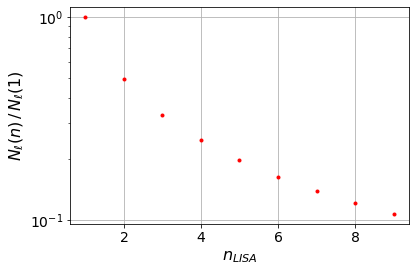

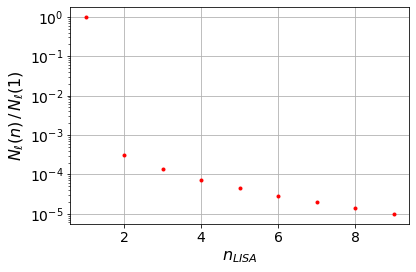

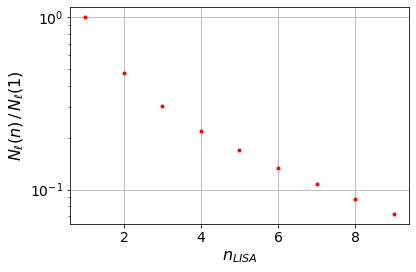

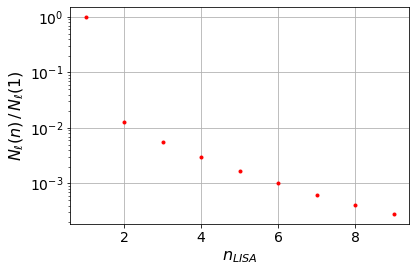

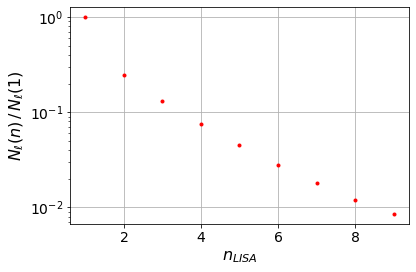

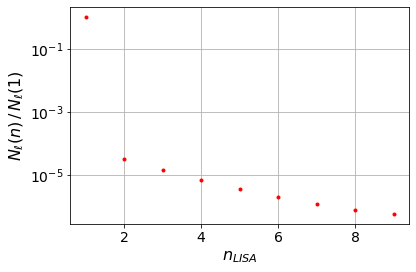

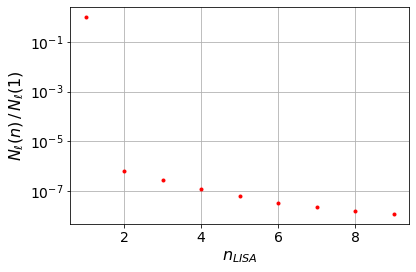

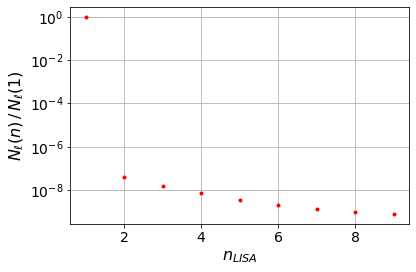

In [36]:
def fit(n, l):
    return 1/n**(l/2+1)
for l in range(0, 8):
    def fit_l(n):
        return fit(n, l)
    compare_ML(l, fit_function=None, nbl=nb_lisas[:], nl_mlisas=nl_MLs[:], relative=True, save=True, rel_val=nl_MLs[0, l])

## Check ML

In [6]:
with open('npy_saves/nlL.npy', 'rb') as file:
    nlL = np.load(file)
with open('npy_saves/nlTL.npy', 'rb') as file:
    nlTL = np.load(file)
with open('npy_saves/nlML_2.npy', 'rb') as file:
    nlML_2 = np.load(file)
with open('npy_saves/nlML_5.npy', 'rb') as file:
    nlML_5 = np.load(file)

In [8]:
nlL = mcL.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)
print('LISA done')
nlTL = mcTL.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)
print('Two LISAs done')

LISA done
Two LISAs done


In [5]:
nlML_2 = mcML_2.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)

In [7]:
nlML_5 = mcML_5.get_N_ell(obs_time, freqs_lr, nside_lr, is_fspacing_log=True)

In [10]:
#np.save('npy_saves/nlL', nlL)
#np.save('npy_saves/nlTL_opposite', nlTL)
#np.save('npy_saves/nlML_2', nlML_2)
#np.save('npy_saves/nlML_5', nlML_5)

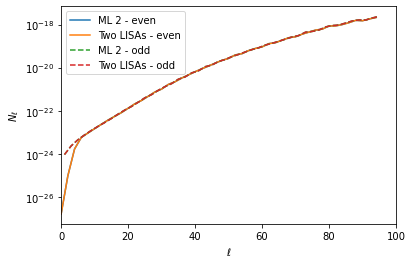

In [9]:
ls = np.arange(len(nlML_2))

plt.plot(ls[::2], ((ls+.5)*nlML_2)[::2], label = 'ML 2 - even')
#plt.plot(ls[::2], ((ls+.5)*nlML_5)[::2], label = 'ML 5 - even')
#plt.plot(ls[::2], ((ls+.5)*nlL)[::2], label = 'LISA - even')
plt.plot(ls[::2], ((ls+.5)*nlTL)[::2], label = 'Two LISAs - even')

plt.plot(ls[1::2], ((ls+.5)*nlML_2)[1::2], '--', label = 'ML 2 - odd')
#plt.plot(ls[::2], ((ls+.5)*nlML_5)[1::2], '--', label = 'ML 5 - odd')
#plt.plot(ls[1::2], ((ls+.5)*nlL)[1::2], '--', label = 'LISA - odd')
plt.plot(ls[1::2], ((ls+.5)*nlTL)[1::2], '--', label = 'Two LISAs - odd')

plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$N_\ell$')
plt.xlim(0, 100)
plt.legend()
plt.show();